In [1]:
import os
import nltk
import json
import random
import datetime 
import numpy as np
import pandas as pd
from keras.preprocessing import sequence
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.model_selection import train_test_split
from nltk.stem.lancaster import LancasterStemmer
stemmer = LancasterStemmer()
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
data=pd.read_csv('svm_smo_wildlife_project.csv')['title'].values

In [3]:
j=pd.read_json('653labels.json')
jf=j['title'].values
labels=j['label'].values
labels=[-1 if i ==0 else 1 for i in labels ]

In [4]:
dat=[*jf, *data]

In [5]:
dat[:5]

['Lot 839: Pair of taxidermy foot stools.',
 'Tigereye and mosasaur tooth ring, fossil tooth ring, tigers eye ring, multi stone ring, statement ring',
 'Whisky brown leather hobo bag - Crossbody everyday leather bag in brown / Bolso de cuero marrón Whisky',
 'Whisky brown leather bag - Crossbody everyday leather bag in brown / Bolso de cuero marrón Whisky - rock&funk collection',
 'Wonderland- rabbit skull jewel beetle and real preserved moth display dome preserved oddities taxidermy']

In [6]:
jf[:5]

array(['Lot 839: Pair of taxidermy foot stools.',
       'Tigereye and mosasaur tooth ring, fossil tooth ring, tigers eye ring, multi stone ring, statement ring',
       'Whisky brown leather hobo bag - Crossbody everyday leather bag in brown / Bolso de cuero marrón Whisky',
       'Whisky brown leather bag - Crossbody everyday leather bag in brown / Bolso de cuero marrón Whisky - rock&funk collection',
       'Wonderland- rabbit skull jewel beetle and real preserved moth display dome preserved oddities taxidermy'],
      dtype=object)

# Data Preparation

for scikit svm, using tfidf scores.

In [7]:
count_vect = CountVectorizer(stop_words='english', lowercase=True)
tfidf_transformer = TfidfTransformer(use_idf=True, smooth_idf=True)
X_train = count_vect.fit_transform(dat)
X_train_tfidf = tfidf_transformer.fit_transform(X_train)
x_train=X_train_tfidf.toarray()

or for smo:

In [7]:
j=pd.read_json('653labels.json')
jf=j[['label','title']]
jf['class']=np.where(jf['label']==0, 'not wildlife product', 'wildlife product')
data=[{"class":i['class'], "sentence":i['title']} for x, i in jf.iterrows()]

words = []
classes = []
documents = []
ignore_words = ['?']
# loop through each sentence in our training data
for pattern in data:
    # tokenize each word in the sentence
    w = nltk.word_tokenize(pattern['sentence'])
    # add to our words list
    words.extend(w)
    # add to documents in our corpus
    documents.append((w, pattern['class']))
    # add to our classes list
    if pattern['class'] not in classes:
        classes.append(pattern['class'])

# stem and lower each word and remove duplicates
words = [stemmer.stem(w.lower()) for w in words if w not in ignore_words]
words = list(set(words))

vocab=[]
vocab_dict={}
for index, word in enumerate(words):
    vocab.append((word,index))
    vocab_dict[word]=index
# remove duplicates
classes = list(set(classes))

training = []
output = []
# create an empty array for our output
output_empty = [0] * len(classes)

# training set, bag of words for each sentence
for doc in documents:
    sent=[stemmer.stem(w.lower()) for w in doc[0]]
    doc_index = [vocab_dict[i] for i in sent]
    training.append(doc_index)
    if doc[1]=='wildlife product':
        output.append(1)
    else:
        output.append(-1)
# # sample training/output
i = 0
w = documents[i][0]

training = np.array(training)
output=np.mat(output).T

(X_train, y_train), (X_test, y_test) = (training[:500],output[:500]), (training[500:],output[500:])


max_review_length = 60
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)



/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
x_train.shape

(21317, 23235)

In [9]:
x=x_train[:653]

In [10]:
x.shape

(653, 23235)

In [11]:
y=np.array(labels)

In [100]:

data=np.mat(x)
labels=np.asarray(labels).reshape(len(labels),1)
labels=y_train
def fx(i,b,data=data, labels=labels, alpha=alpha):
    
    return np.multiply(alpha,labels).T*data*i.T-b

In [ ]:

def smo_svm(data, labels, tol=10**-3, n=653, C=0.1, b=0.1, passes=0):
    alpha=np.zeros((653,1))
    alpha_old=np.zeros((n,1))
    
    while passes<100:
        num_changed_alphas=0
        for i in range(n):
            Ei=fx(data[i], b)-labels[i]
            if ((labels[i]*Ei<-tol and alpha[i]<=C) or (labels[i]*Ei>tol and alpha[i]>0)):
                r=[a for a in range(n)]
                r.pop(i)
                j=random.choice(r)
                Ej=fx(data[j],b)-labels[j]
                alpha_old[i]=alpha[i]
                alpha_old[j]=alpha[j]
                if labels[i]==labels[j]:
                    L=max(0, alpha[j]-alpha[i])
                    H=max(C, C+alpha[j]-alpha[i])
                else:
                    L=max(0, alpha[j]+alpha[i]-C)
                    H=max(C, alpha[j]-alpha[i])
                if L==H:
                    continue
                eta=2*np.inner(data[i],data[j])-np.inner(data[i],data[i])-np.inner(data[j],data[j])
                if eta>=0:
                    print(eta)
                    continue
                alpha[j]=alpha[j]-((labels[j]*(Ei-Ej))/eta)
                if alpha[j]>H:
                    alpha[j]=H
                elif alpha[j]<L:
                    alpha[j]=L

                if np.linalg.norm(alpha[j]-alpha_old[j])<10**-5:
                    continue

                alpha[i]=alpha[i]+labels[i]*labels[j]*(alpha_old[j]-alpha[j])

                b1=b-Ei-(labels[i]*(alpha[i]-alpha_old[i])*np.inner(data[i],data[i]))-(labels[j]*(alpha[j]-alpha_old[j])*np.inner(data[i],data[j]))
                b2=b-Ej-(labels[i]*(alpha[i]-alpha_old[i])*np.inner(data[i],data[j]))-(labels[j]*(alpha[j]-alpha_old[j])*np.inner(data[j],data[j]))

                if 0<alpha[i]<C:
                    b=b1
                elif 0<alpha[j]<C:
                    b=b2
                else:
                    b=(b1+b2)/2

                num_changed_alphas+=1


        if num_changed_alphas==0:
            passes+=1
        else:
            passes=0
#             print(num_changed_alphas)\
    return alpha
            


In [39]:
import pylab as pl

In [69]:
def svm_clf(c, k, n=500, x=x, y=y):
    pca = PCA(n_components=2).fit(x)
    pca_2d = pca.transform(x)
#     svmClassifier_2d =   svm.LinearSVC(random_state=111).fit(pca_2d[:500], y[:500])
    svmClassifier_2d=SVC(C=c, kernel=k, probability=True).fit(pca_2d[:500], y[:500])
#     print('acc :',svmClassifier_2d.score(pca_2d[500:], y[500:]))
    for i in range(pca_2d.shape[0]):
        if y[i] == -1:
            c1 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='r',    s=50,marker='+')
        elif y[i] == 1:
            c2 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='g',    s=50,marker='o')
    pl.legend([c1, c2], ['non-wildlife', 'wildlife'])
    x_min, x_max = pca_2d[:, 0].min() - 1,   pca_2d[:,0].max() + 1
    y_min, y_max = pca_2d[:, 1].min() - 1,   pca_2d[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, .01),   np.arange(y_min, y_max, .01))
    Z = svmClassifier_2d.predict(np.c_[xx.ravel(),  yy.ravel()])
    Z = Z.reshape(xx.shape)
    pl.contour(xx, yy, Z)
    pl.title('Support Vector Machine -'+ k)
    pl.axis('off')
    pl.show()

c : 0.1
acc : 0.7581699346405228


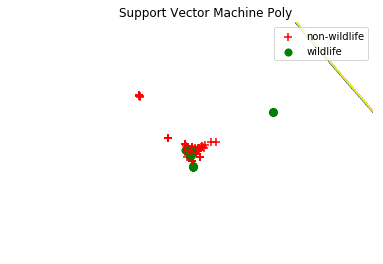

c : 1
acc : 0.7712418300653595


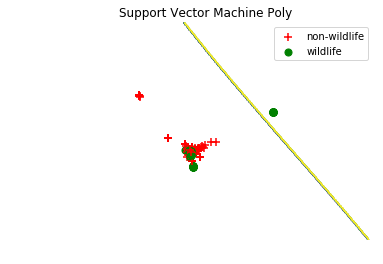

c : 10
acc : 0.7712418300653595


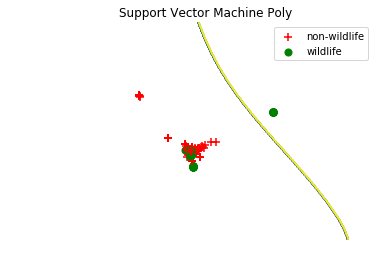

c : 50
acc : 0.7712418300653595


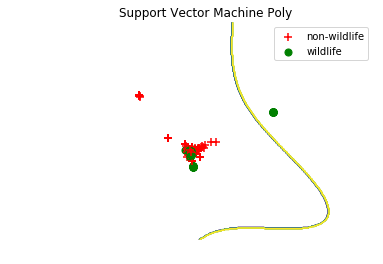

c : 100
acc : 0.7712418300653595


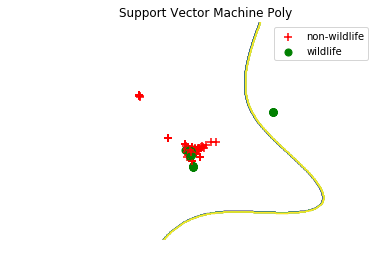

c : 500
acc : 0.7712418300653595


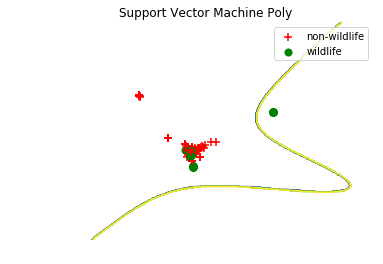

c : 1000
acc : 0.7712418300653595


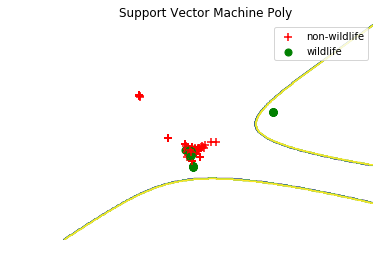

c : 2000
acc : 0.7712418300653595


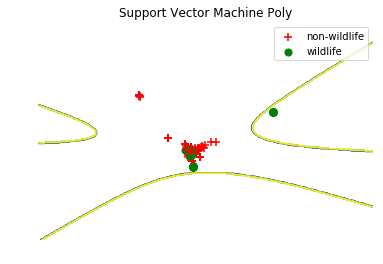

In [63]:
ll=[0.1, 1, 10, 50, 100, 500, 1000, 2000]
for l in ll:
    print ('c :',l)
    svm_clf(c=l, k='poly')

c : 0.1
acc : 0.7581699346405228


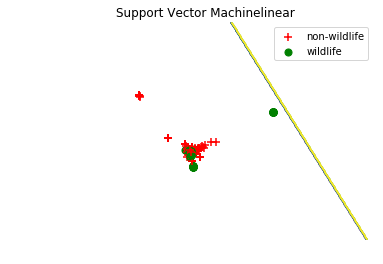

c : 1
acc : 0.7712418300653595


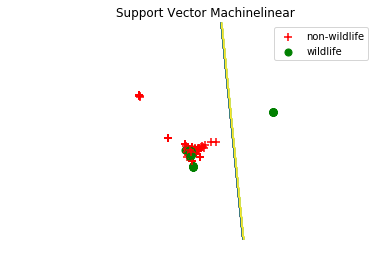

c : 10
acc : 0.7712418300653595


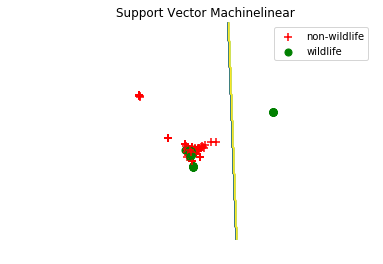

c : 50
acc : 0.7712418300653595


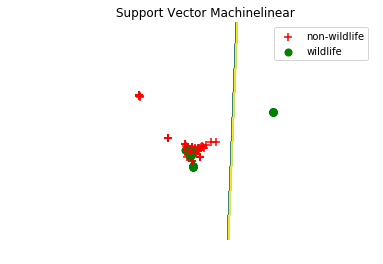

c : 100
acc : 0.7712418300653595


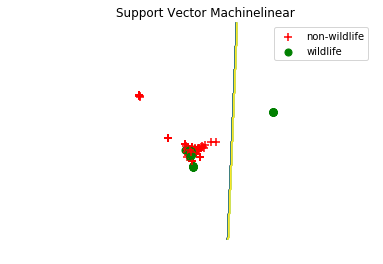

c : 500
acc : 0.7712418300653595


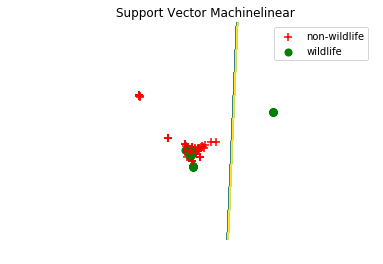

c : 1000
acc : 0.7712418300653595


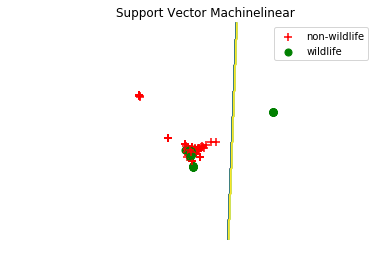

c : 2000
acc : 0.7712418300653595


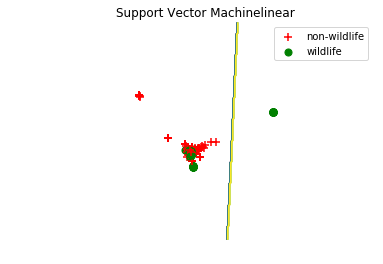

In [67]:
ll=[0.1, 1, 10, 50, 100, 500, 1000, 2000]
for l in ll:
    print ('c :',l)
    svm_clf(c=l, k='linear')

c : 0.1


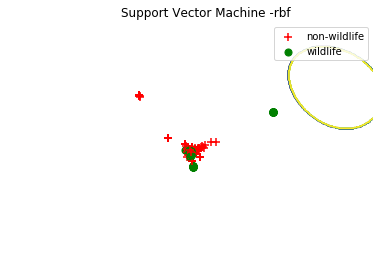

c : 1


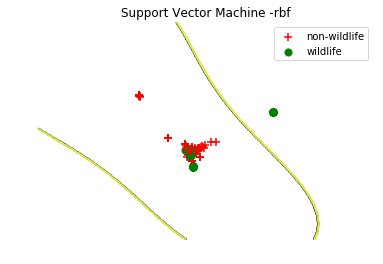

c : 10


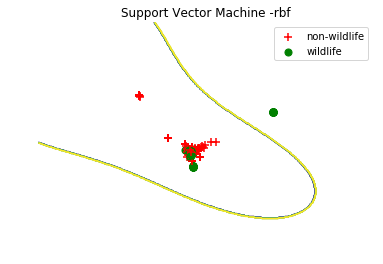

c : 50


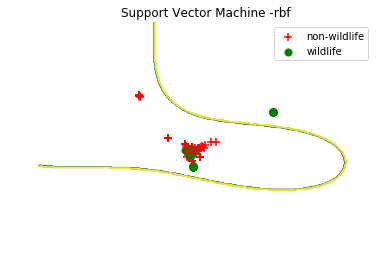

c : 100


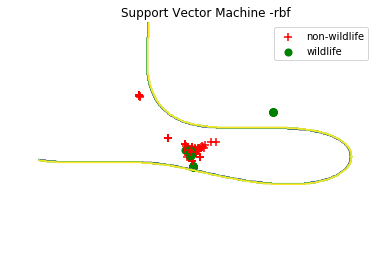

c : 500


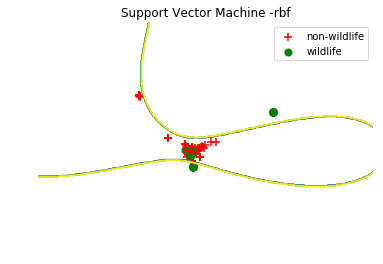

c : 1000


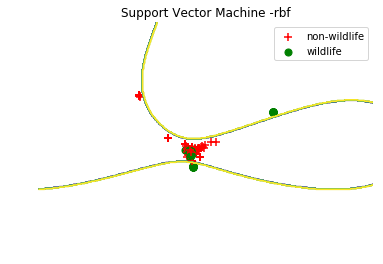

c : 2000


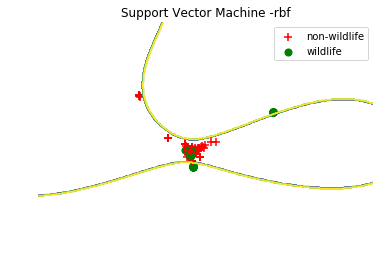

In [70]:
ll=[0.1, 1, 10, 50, 100, 500, 1000, 2000]
for l in ll:
    print ('c :',l)
    svm_clf(c=l, k='rbf')

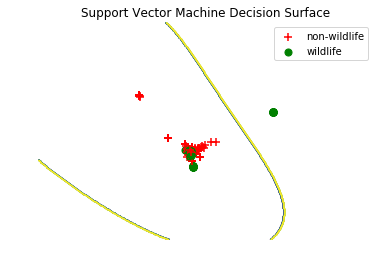

In [199]:
svm_clf()

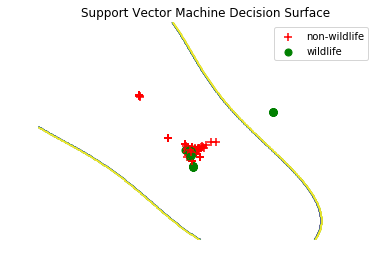

In [201]:
svm_clf()

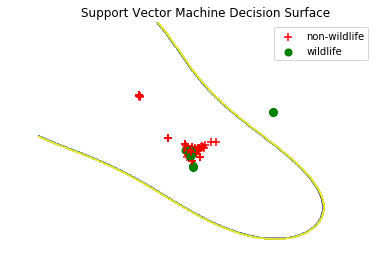

In [203]:
svm_clf()


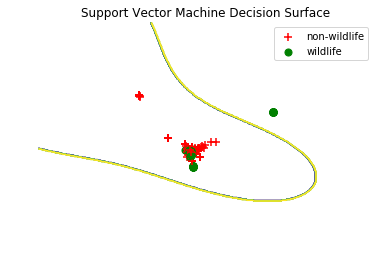

In [205]:
svm_clf()

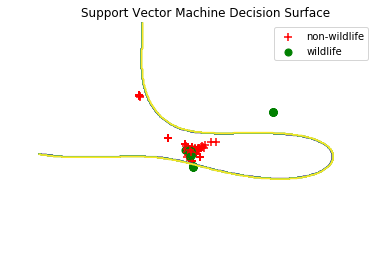

In [207]:
svm_clf()

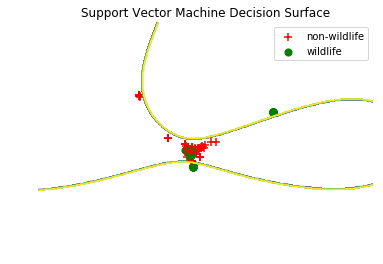

In [209]:
svm_clf()